In [1]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

import csv

Using TensorFlow backend.


In [2]:
#Loading in the movies dataset
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Loading the ratings dataset
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
len(movies_df)

3883

In [7]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
user_rating_df[user_rating_df.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
215,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
trX[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0., 0., 1., ..., 0., 0., 0.])

In [11]:
errors_DBN=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.5  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [12]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [13]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.098530
Epoch: 1 reconstruction error: 0.072706
Epoch: 2 reconstruction error: 0.063415
Epoch: 3 reconstruction error: 0.058879
Epoch: 4 reconstruction error: 0.054326
Epoch: 5 reconstruction error: 0.051152
Epoch: 6 reconstruction error: 0.049686
Epoch: 7 reconstruction error: 0.048144
Epoch: 8 reconstruction error: 0.047389
Epoch: 9 reconstruction error: 0.046587
Epoch: 10 reconstruction error: 0.045972
Epoch: 11 reconstruction error: 0.045516
Epoch: 12 reconstruction error: 0.045108
Epoch: 13 reconstruction error: 0.044565
Epoch: 14 reconstruction error: 0.044133
New RBM:
Epoch: 0 reconstruction error: 0.001202
Epoch: 1 reconstruction error: 0.000744
Epoch: 2 reconstruction error: 0.000965
Epoch: 3 reconstruction error: 0.000626
Epoch: 4 reconstruction error: 0.000846
Epoch: 5 reconstruction error: 0.001403
Epoch: 6 reconstruction error: 0.000852
Epoch: 7 reconstruction error: 0.000925
Epoch: 

In [14]:
errors_DBN_1=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_1.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [15]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [16]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.061138
Epoch: 1 reconstruction error: 0.055004
Epoch: 2 reconstruction error: 0.050621
Epoch: 3 reconstruction error: 0.047916
Epoch: 4 reconstruction error: 0.045908
Epoch: 5 reconstruction error: 0.044112
Epoch: 6 reconstruction error: 0.043058
Epoch: 7 reconstruction error: 0.041647
Epoch: 8 reconstruction error: 0.041509
Epoch: 9 reconstruction error: 0.040547
Epoch: 10 reconstruction error: 0.039590
Epoch: 11 reconstruction error: 0.039436
Epoch: 12 reconstruction error: 0.038703
Epoch: 13 reconstruction error: 0.038218
Epoch: 14 reconstruction error: 0.038283
New RBM:
Epoch: 0 reconstruction error: 0.000316
Epoch: 1 reconstruction error: 0.000402
Epoch: 2 reconstruction error: 0.000456
Epoch: 3 reconstruction error: 0.000528
Epoch: 4 reconstruction error: 0.000563
Epoch: 5 reconstruction error: 0.000593
Epoch: 6 reconstruction error: 0.000598
Epoch: 7 reconstruction error: 0.000624
Epoch: 8 reconstruction error: 0.000630
Epoch: 9 reconstr

In [17]:
errors_DBN_2=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.25  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_2.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [18]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [19]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.111143
Epoch: 1 reconstruction error: 0.071481
Epoch: 2 reconstruction error: 0.057133
Epoch: 3 reconstruction error: 0.051209
Epoch: 4 reconstruction error: 0.047934
Epoch: 5 reconstruction error: 0.045817
Epoch: 6 reconstruction error: 0.044458
Epoch: 7 reconstruction error: 0.043341
Epoch: 8 reconstruction error: 0.042512
Epoch: 9 reconstruction error: 0.041752
Epoch: 10 reconstruction error: 0.041262
Epoch: 11 reconstruction error: 0.040642
Epoch: 12 reconstruction error: 0.040259
Epoch: 13 reconstruction error: 0.039749
Epoch: 14 reconstruction error: 0.039422
New RBM:
Epoch: 0 reconstruction error: 0.000492
Epoch: 1 reconstruction error: 0.000771
Epoch: 2 reconstruction error: 0.000582
Epoch: 3 reconstruction error: 0.000535
Epoch: 4 reconstruction error: 0.000570
Epoch: 5 reconstruction error: 0.000549
Epoch: 6 reconstruction error: 0.000679
Epoch: 7 reconstruction error: 0.000566
Epoch: 8 reconstruction error: 0.000606
Epoch: 9 reconstr

In [20]:
errors_DBN_3=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.01  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_3.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [21]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [22]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.074125
Epoch: 1 reconstruction error: 0.063868
Epoch: 2 reconstruction error: 0.060090
Epoch: 3 reconstruction error: 0.057980
Epoch: 4 reconstruction error: 0.056572
Epoch: 5 reconstruction error: 0.055393
Epoch: 6 reconstruction error: 0.054206
Epoch: 7 reconstruction error: 0.053168
Epoch: 8 reconstruction error: 0.052122
Epoch: 9 reconstruction error: 0.051363
Epoch: 10 reconstruction error: 0.050800
Epoch: 11 reconstruction error: 0.050191
Epoch: 12 reconstruction error: 0.049847
Epoch: 13 reconstruction error: 0.049343
Epoch: 14 reconstruction error: 0.048943
New RBM:
Epoch: 0 reconstruction error: 0.027848
Epoch: 1 reconstruction error: 0.012089
Epoch: 2 reconstruction error: 0.007596
Epoch: 3 reconstruction error: 0.005559
Epoch: 4 reconstruction error: 0.004308
Epoch: 5 reconstruction error: 0.003551
Epoch: 6 reconstruction error: 0.003052
Epoch: 7 reconstruction error: 0.002675
Epoch: 8 reconstruction error: 0.002393
Epoch: 9 reconstr

In [23]:
errors_DBN_4=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_4.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [24]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [25]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.072815
Epoch: 1 reconstruction error: 0.059390
Epoch: 2 reconstruction error: 0.055116
Epoch: 3 reconstruction error: 0.053179
Epoch: 4 reconstruction error: 0.052167
Epoch: 5 reconstruction error: 0.051534
Epoch: 6 reconstruction error: 0.050997
Epoch: 7 reconstruction error: 0.050694
Epoch: 8 reconstruction error: 0.050576
Epoch: 9 reconstruction error: 0.050297
Epoch: 10 reconstruction error: 0.050264
Epoch: 11 reconstruction error: 0.050188
Epoch: 12 reconstruction error: 0.050053
Epoch: 13 reconstruction error: 0.050003
Epoch: 14 reconstruction error: 0.049957
New RBM:
Epoch: 0 reconstruction error: 0.000026
Epoch: 1 reconstruction error: 0.000083
Epoch: 2 reconstruction error: 0.000227
Epoch: 3 reconstruction error: 0.000599
Epoch: 4 reconstruction error: 0.000825
Epoch: 5 reconstruction error: 0.000881
Epoch: 6 reconstruction error: 0.000847
Epoch: 7 reconstruction error: 0.000892
Epoch: 8 reconstruction error: 0.000936
Epoch: 9 reconstr

In [26]:
errors_DBN_5=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.075  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_5.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [27]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [28]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.055939
Epoch: 1 reconstruction error: 0.053083
Epoch: 2 reconstruction error: 0.050018
Epoch: 3 reconstruction error: 0.047270
Epoch: 4 reconstruction error: 0.045875
Epoch: 5 reconstruction error: 0.044629
Epoch: 6 reconstruction error: 0.043543
Epoch: 7 reconstruction error: 0.042267
Epoch: 8 reconstruction error: 0.041170
Epoch: 9 reconstruction error: 0.040512
Epoch: 10 reconstruction error: 0.040305
Epoch: 11 reconstruction error: 0.039984
Epoch: 12 reconstruction error: 0.039191
Epoch: 13 reconstruction error: 0.038894
Epoch: 14 reconstruction error: 0.038519
New RBM:
Epoch: 0 reconstruction error: 0.001206
Epoch: 1 reconstruction error: 0.000991
Epoch: 2 reconstruction error: 0.000895
Epoch: 3 reconstruction error: 0.000840
Epoch: 4 reconstruction error: 0.000787
Epoch: 5 reconstruction error: 0.000752
Epoch: 6 reconstruction error: 0.000726
Epoch: 7 reconstruction error: 0.000738
Epoch: 8 reconstruction error: 0.000729
Epoch: 9 reconstr

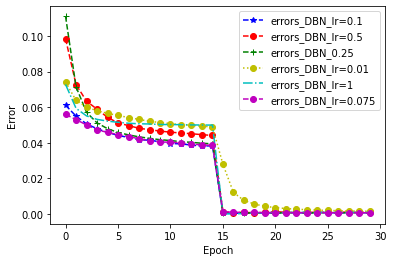

In [29]:
plt.plot(errors_DBN_1,'--*b',label='errors_DBN_lr=0.1')
plt.plot(errors_DBN,'--or',label='errors_DBN_lr=0.5')
plt.plot(errors_DBN_2,'--+g',label='errors_DBN_0.25')
plt.plot(errors_DBN_3,'o:y',label='errors_DBN_lr=0.01')
plt.plot(errors_DBN_4,'-.c',label='errors_DBN_lr=1')
plt.plot(errors_DBN_5,'--om',label='errors_DBN_lr=0.075')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

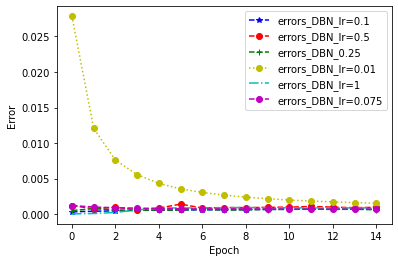

In [30]:
errors_DBN_11=errors_DBN_1[15:30]
errors_DBN_21=errors_DBN_2[15:30]
errors_DBN_31=errors_DBN_3[15:30]
errors_DBN_41=errors_DBN_4[15:30]
errors_DBN1=errors_DBN[15:30]
errors_DBN_51=errors_DBN_5[15:30]

plt.plot(errors_DBN_11,'--*b',label='errors_DBN_lr=0.1')
plt.plot(errors_DBN1,'--or',label='errors_DBN_lr=0.5')
plt.plot(errors_DBN_21,'--+g',label='errors_DBN_0.25')
plt.plot(errors_DBN_31,'o:y',label='errors_DBN_lr=0.01')
plt.plot(errors_DBN_41,'-.c',label='errors_DBN_lr=1')
plt.plot(errors_DBN_51,'--om',label='errors_DBN_lr=0.075')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()